# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt

Note: 
1. Importing `imageio` library for `imread` as latest version of `scipy.misc` library does not have attribute `imread` or `imresize`
2. Importing `skimage` library for using `resize` option for images 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('D:/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('D:/Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i*2 for i in range(15)]               #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size   # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            batch_data = np.zeros((batch_size,x,50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_img=resize(image,(50,50))
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        seq_left = len(folder_list)%batch_size # To calculate the number of sequences left
        batch=batch+1
        batch_sizen=seq_left  #New batch size within this block will be left over sequence
        if(seq_left!=0):
            for batch in tf.range(batch_sizen):
                batch_data = np.zeros((batch_sizen,x,50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_sizen,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_sizen): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_sizen)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_sizen)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes

                        resized_img = resize(image,(50,50))

                        batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255
                        batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255
                        batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_sizen)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'D:/Project_data/train'
val_path = 'D:/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes=5

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model 1: Conv2D+RNN (GRU)

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(TimeDistributed(tf.keras.layers.Conv2D(16,(2,2),padding='same'),input_shape=(15,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(tf.keras.layers.Conv2D(16,(2,2),padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(tf.keras.layers.Conv2D(32,(2,2),padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(tf.keras.layers.Conv2D(32,(2,2),padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, return_sequences=False,dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 50, 50, 16)    208       
_________________________________________________________________
activation (Activation)      (None, 15, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 50, 50, 16)    1040      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 25, 25, 16)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### `Final Model`: Epochs=50, Batch Size=32, Image Size=(50,50,3), Number of Images from a Sequence =15
Total params: 3,761,701 | Trainable params: 3,761,509 | Non-trainable params: 192

In [11]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/Project_data/train ; batch size = 32
Source path =  D:/Project_data/val ; batch size = 32
Train for 21 steps, validate for 4 steps
Epoch 1/50
20/21 [===========================>..] - ETA: 10s - loss: 2.5105 - categorical_accuracy: 0.3500
Epoch 00001: saving model to model_init_2022-03-0219_44_06.527897/model-00001-2.45768-0.33937-2.38506-0.20000.h5
21/21 [==============================] - 294s 14s/step - loss: 2.4389 - categorical_accuracy: 0.3394 - val_loss: 2.3851 - val_categorical_accuracy: 0.2000
Epoch 2/50
20/21 [===========================>..] - ETA: 3s - loss: 2.0409 - categorical_accuracy: 0.5359
Epoch 00002: saving model to model_init_2022-03-0219_44_06.527897/model-00002-2.00008-0.52640-4.01746-0.14844.h5
21/21 [==============================] - 136s 6s/step - loss: 1.9856 - categorical_accuracy: 0.5264 - val_loss: 4.0175 - val_categorical_accuracy: 0.1484
Epoch 3/50
20/21 [===========================>..] - ETA: 3s - loss: 1.6512 - categorical_accuracy: 0.69

Epoch 23/50
20/21 [===========================>..] - ETA: 3s - loss: 0.5098 - categorical_accuracy: 0.9125
Epoch 00023: saving model to model_init_2022-03-0219_44_06.527897/model-00023-0.50216-0.88989-1.32480-0.65000.h5
21/21 [==============================] - 124s 6s/step - loss: 0.4994 - categorical_accuracy: 0.8899 - val_loss: 1.3248 - val_categorical_accuracy: 0.6500
Epoch 24/50
20/21 [===========================>..] - ETA: 3s - loss: 0.5010 - categorical_accuracy: 0.9234
Epoch 00024: saving model to model_init_2022-03-0219_44_06.527897/model-00024-0.49374-0.90196-1.46826-0.53000.h5
21/21 [==============================] - 126s 6s/step - loss: 0.4911 - categorical_accuracy: 0.9020 - val_loss: 1.4683 - val_categorical_accuracy: 0.5300
Epoch 25/50
20/21 [===========================>..] - ETA: 3s - loss: 0.4865 - categorical_accuracy: 0.9297
Epoch 00025: saving model to model_init_2022-03-0219_44_06.527897/model-00025-0.48022-0.90045-1.21458-0.68000.h5
21/21 [=========================

Epoch 45/50
20/21 [===========================>..] - ETA: 3s - loss: 1.1980 - categorical_accuracy: 0.8781
Epoch 00045: saving model to model_init_2022-03-0219_44_06.527897/model-00045-1.18333-0.85370-1.09182-0.85000.h5
21/21 [==============================] - 127s 6s/step - loss: 1.1781 - categorical_accuracy: 0.8537 - val_loss: 1.0918 - val_categorical_accuracy: 0.8500
Epoch 46/50
20/21 [===========================>..] - ETA: 3s - loss: 1.2667 - categorical_accuracy: 0.8609
Epoch 00046: saving model to model_init_2022-03-0219_44_06.527897/model-00046-1.25126-0.83861-1.28103-0.83594.h5
21/21 [==============================] - 129s 6s/step - loss: 1.2458 - categorical_accuracy: 0.8386 - val_loss: 1.2810 - val_categorical_accuracy: 0.8359
Epoch 47/50
20/21 [===========================>..] - ETA: 3s - loss: 1.3097 - categorical_accuracy: 0.8516
Epoch 00047: saving model to model_init_2022-03-0219_44_06.527897/model-00047-1.29702-0.82655-1.70828-0.74000.h5
21/21 [=========================

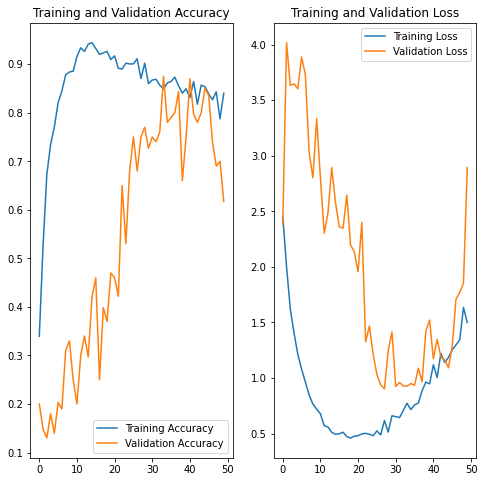

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
print("Training Accuracy", max(history.history['categorical_accuracy']), "Validation Accuracy",max(history.history['val_categorical_accuracy']))

Training Accuracy 0.94419307 Validation Accuracy 0.875
